Import the nessesary materials for this project

In [8]:
import numpy as np
!pip install sep
import sep

In [24]:

from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Ellipse
from google.colab import drive
drive.mount('/content/drive')


%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


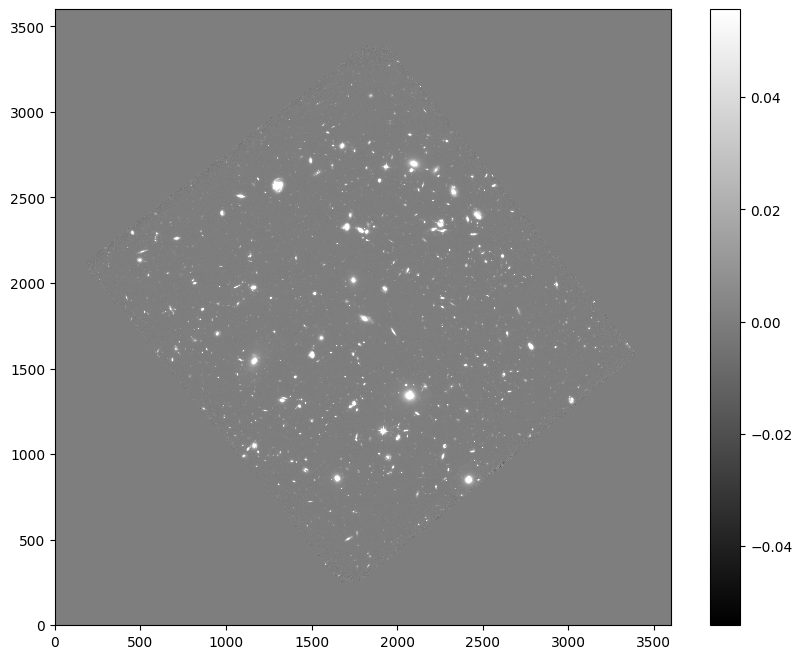

In [12]:
# read the image into standard 2-d numpy array
image_data = "/content/drive/MyDrive/ASTR19_final/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits"
hdu_data = fits.open(image_data)
#primary_hdu2 = hdu2[0]
data = hdu_data[0].data
data = data.byteswap().newbyteorder()

# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

In [17]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

In [14]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)


0.0
0.0005398219218477607


In [18]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

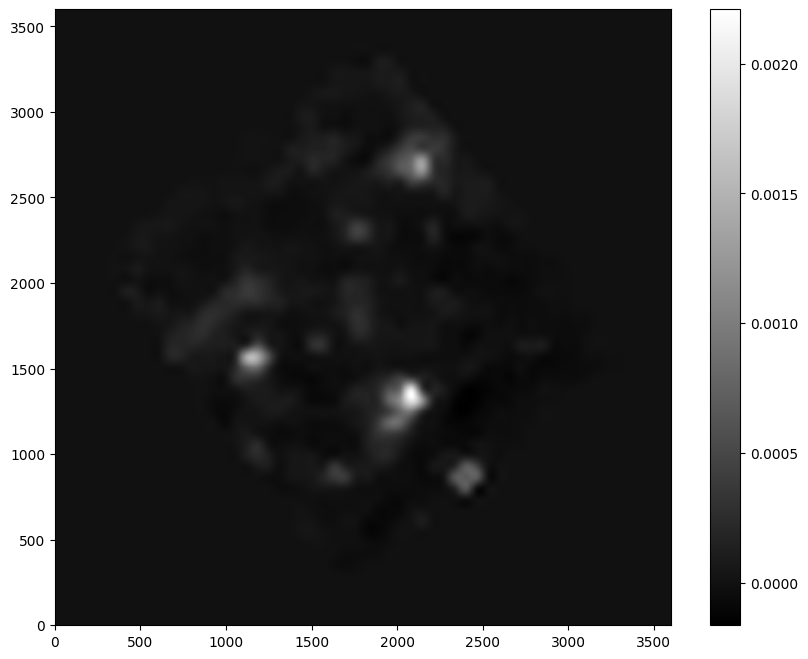

In [20]:
# show the grackground
plt.imshow(bkg_image, interpolation='nearest', cmap='gray',origin='lower')
plt.colorbar();

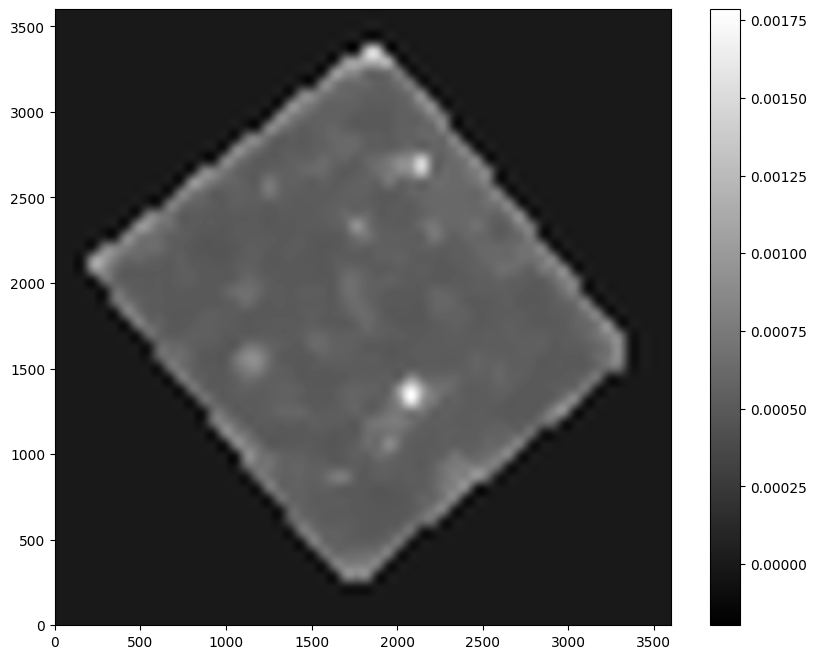

In [22]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();

In [23]:
# subtract the background
data_sub = data - bkg

#find objects
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

# how many objects were detected
len(objects)

8643

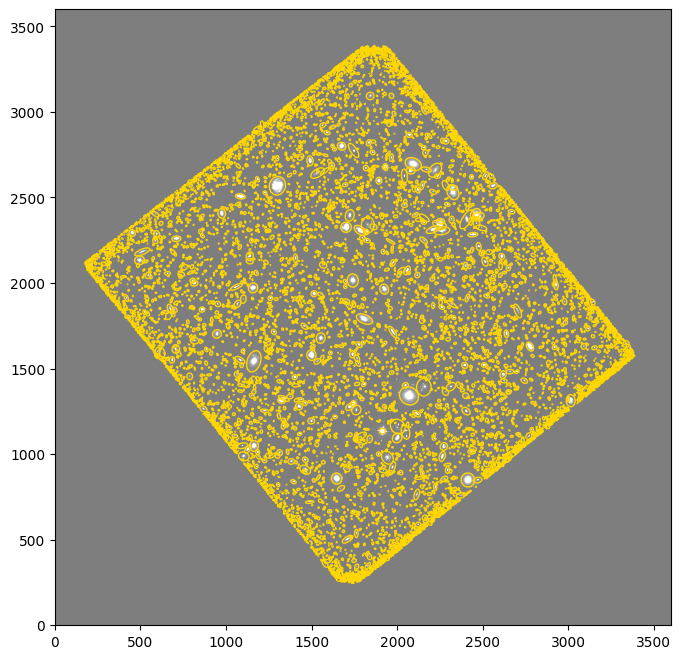

In [27]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('gold')
    ax.add_artist(e)

In [28]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

# show the first 10 objects results:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


#Hestogram their fluxes

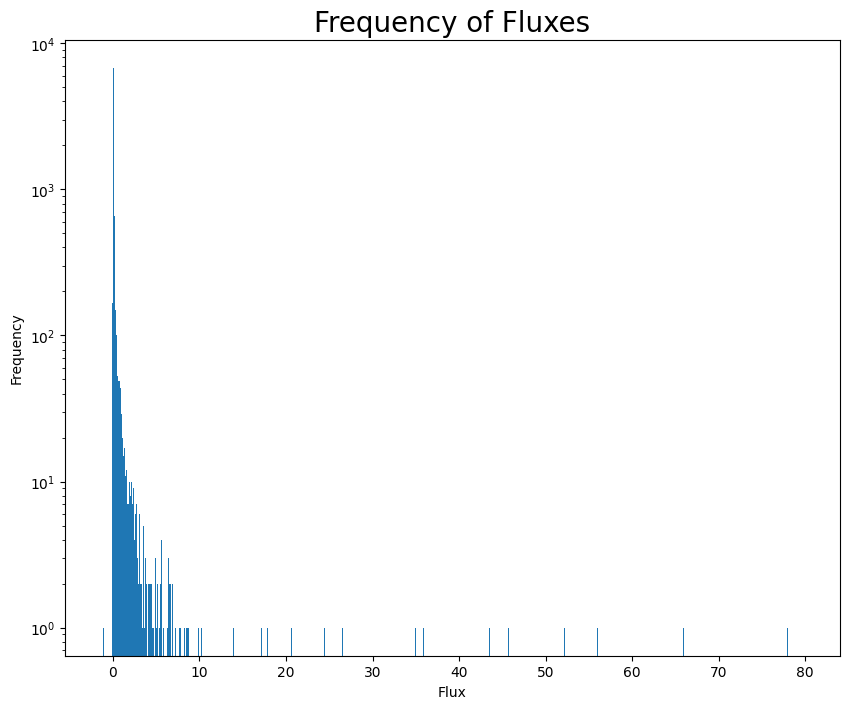

In [31]:
#Defining bin parameters
width = 0.1
min = -1.5
max = 80

bins = np.arange(min, max, width)

# Plotting histograms
plt.hist(flux, bins=bins, alpha=1)
plt.xlabel('Flux')
plt.ylabel('Frequency')
plt.yscale('log')    #Needed to properly visualize
plt.title('Frequency of Fluxes',size=20)
plt.show()

#Mean, median, and standard deviation of the fluxes

In [43]:
mean = np.mean(flux)
median = np.median(flux)
std = np.std(flux)

print(f' The Mean of the fluxes is {mean:5.5} \
\n The median of the fluxes is {median:5.5}\
\n The Standard deviation between the fluxes is {std:5.5}')

 The Mean of the fluxes is 0.36175 
 The median of the fluxes is 0.030955
 The Standard deviation between the fluxes is 9.2419


#Finding the lagrest outlier

In [48]:
z_scores = np.abs((flux - np.mean(flux)) / np.std(flux))
outliers = np.array((flux)[z_scores > 3], order='A')
sorted_outies = np.sort(outliers)    # sort the outliers from smallest to largest
size = np.size(outliers)    # number of outliers
largest_outlier = sorted_outies[size-1] # finding the largest outlier

# How many std is it away from the mean?
def deviations(largest_outlier,mean,std):
  num_of_std = ((largest_outlier - mean) / std)
  return num_of_std #how many std where there

num_of_std = deviations(largest_outlier,mean,std)
print(f' The largest outlier is {largest_outlier:5.5} and it is {num_of_std:5.5} standard deviations away from the mean')

 The largest outlier is 807.3 and it is 87.312 standard deviations away from the mean


#RGB 3-color false image

In [50]:
# Opening the files
data_F125 = "/content/drive/MyDrive/ASTR19_final/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits"
data_F160 = "/content/drive/MyDrive/ASTR19_final/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits"

# read the data using astropy fits
hdu_125 = fits.open(data_F125)
hdu_160 = fits.open(data_F160)

#Getting all the image data
F105_data = hdu_data[0].data
F125_data = hdu_125[0].data
F160_data = hdu_160[0].data


In [52]:
# rescaling the image
def rescale_image(data):
    # copy the data to avoid accidentally overwritng it
    pdata_tmp = data.copy()

    # compute the mean anywhere exect for places what don't have a number (thats why there np.nanmean)
    n = np.nanmean(pdata_tmp)

    # if lower than vpmin, apply vpmin
    # if higher than vpmax, apply vpmax
    vpmin = 0.5*n
    vpmax = 100*n
    pdata_tmp[pdata_tmp < vpmin] = vpmin
    pdata_tmp[pdata_tmp > vpmax] = vpmax
    pdata_tmp = np.nan_to_num(pdata_tmp,nan=vpmin)

    # scale by log10
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp

In [53]:
# Now we have the rescaled data
F105_data_rs = rescale_image(F105_data)
F125_data_rs = rescale_image(F125_data)
F160_data_rs = rescale_image(F160_data)

In [55]:
# Combine data, then use RGB formatting
data_all = np.zeros((F105_data.shape[0],F105_data.shape[1],3))    # shape of F105W in two dimensions, then 2 layers

data_all[:,:,0] = F125_data   #layer 0; red is filter F125W
data_all[:,:,1] = F160_data   #layer 1; green is filter F160W
data_all[:,:,2] = F105_data   #layer 2; blue is filter F105W

data_all_rs = rescale_image(data_all)

In [56]:
# now the remapping happen
def remap(data):
    pdata_tmp = data.copy()  # copy the data
    dmin = pdata_tmp.min()
    dmax = pdata_tmp.max()
    return (pdata_tmp - dmin)/(dmax-dmin)

In [57]:
rgb_image = np.zeros((F105_data.shape[0], F105_data.shape[1],2))

rgb_image = remap(data_all_rs)

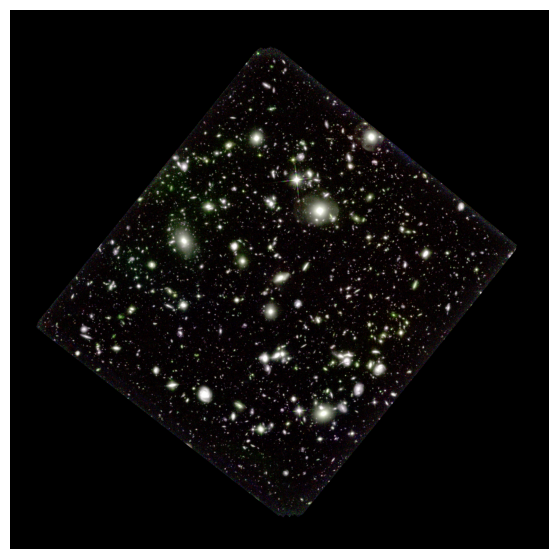

In [60]:
# Plot the RGB image and save to a PNG

f,ax = plt.subplots(1,1,figsize=(7,7))
ax.axis('off')
ax.imshow(rgb_image)
plt.savefig('HUDF_RGB.png',bbox_inches='tight',pad_inches=0,dpi=600)